In [1]:
%load_ext autoreload
%autoreload 2

import seaborn # icefire 
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy

# package settings
np.random.seed(42)

import perc
from perc.utils import calc_energy
import perc.vis as vis

# Constants

In [ ]:
### Data Constants
DT = 0.05
TEST_PERC = 0.9
TN = 100
FCAST_LEN = 4_000

### RC Configuration
RC_CONFIG = {
    'Nu': -1, # will fill in later
    'Nr': 100,
    'alpha': 0.6,
    'beta': 8e-8,
    'rho_A': 0.02,
    'lambda_max': 0.8,
    'sigma': 0.084,
    'bias': 0.0,
    'spinup': 0,
    'f': np.tanh
}

# Load data 

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

U_train shape: (4, 199)
U_test shape: (4, 1801)


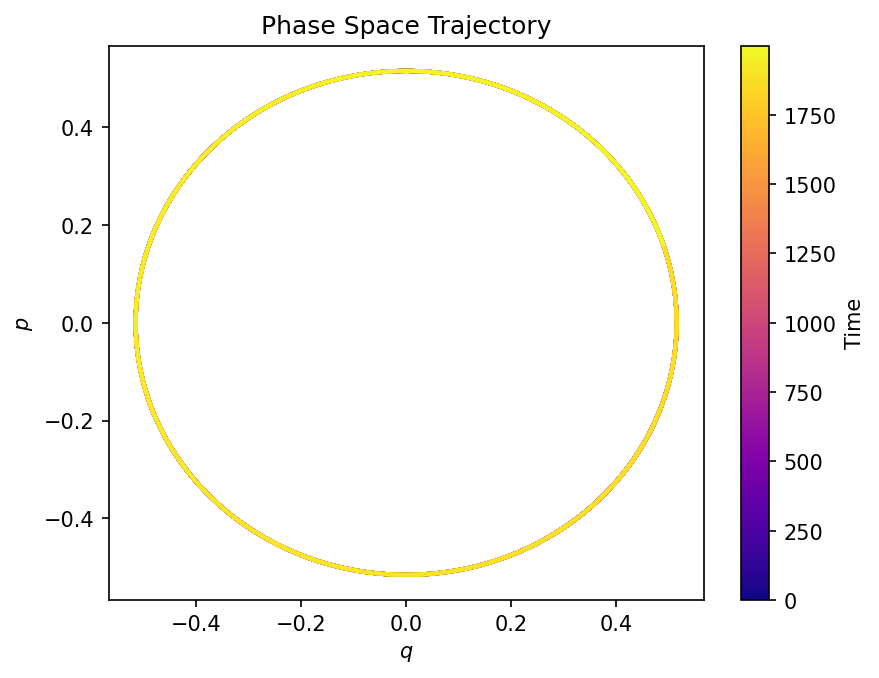

In [3]:
### Obtain + process data

# initial conditions
u0 = np.random.randn(2)

# integrate hamiltonian MSD
def f(t,u,m,k):
    q,p = u 
    qdot = p/m
    pdot = -k*q
    return np.array([qdot, pdot])
ts = np.arange(0,TN,DT)
sol = scipy.integrate.solve_ivp(f, t_span=(0,TN),
                                y0=u0,
                                dense_output=True,
                                method='DOP853', # make sure energy is conserved from integrator
                                rtol=1e-12,
                                atol=1e-12,
                                args=(1,1))

# linear constraints (energy conservation)
C = np.array([[0,0,1,1]])
d = np.array([[u0[0]**2 + u0[1]**2]])

# add in quadratic terms
U = sol.sol(ts)
U = np.concatenate((U, np.zeros((2, U.shape[1]))), axis=0)
U[2,:] = U[0,:] ** 2 
U[3,:] = U[1,:] ** 2
t = ts
RC_CONFIG['Nu'] = U.shape[0]  #as promised 

# train-test split
split_idx = int((1-TEST_PERC) * U.shape[1])
U_train = U[:, :split_idx]
U_test = U[:, split_idx:]
t_train = t[:split_idx] 
t_test = np.arange(U_test.shape[1]) * DT  # start from 0
print(f"U_train shape: {U_train.shape}")
print(f"U_test shape: {U_test.shape}")

# calc error on test set
C_err_utest = (C@U_test - d).reshape(-1)

# plot phase space
vis.plot_phase_space(U[:2,:])

# Train Unconstrained RC

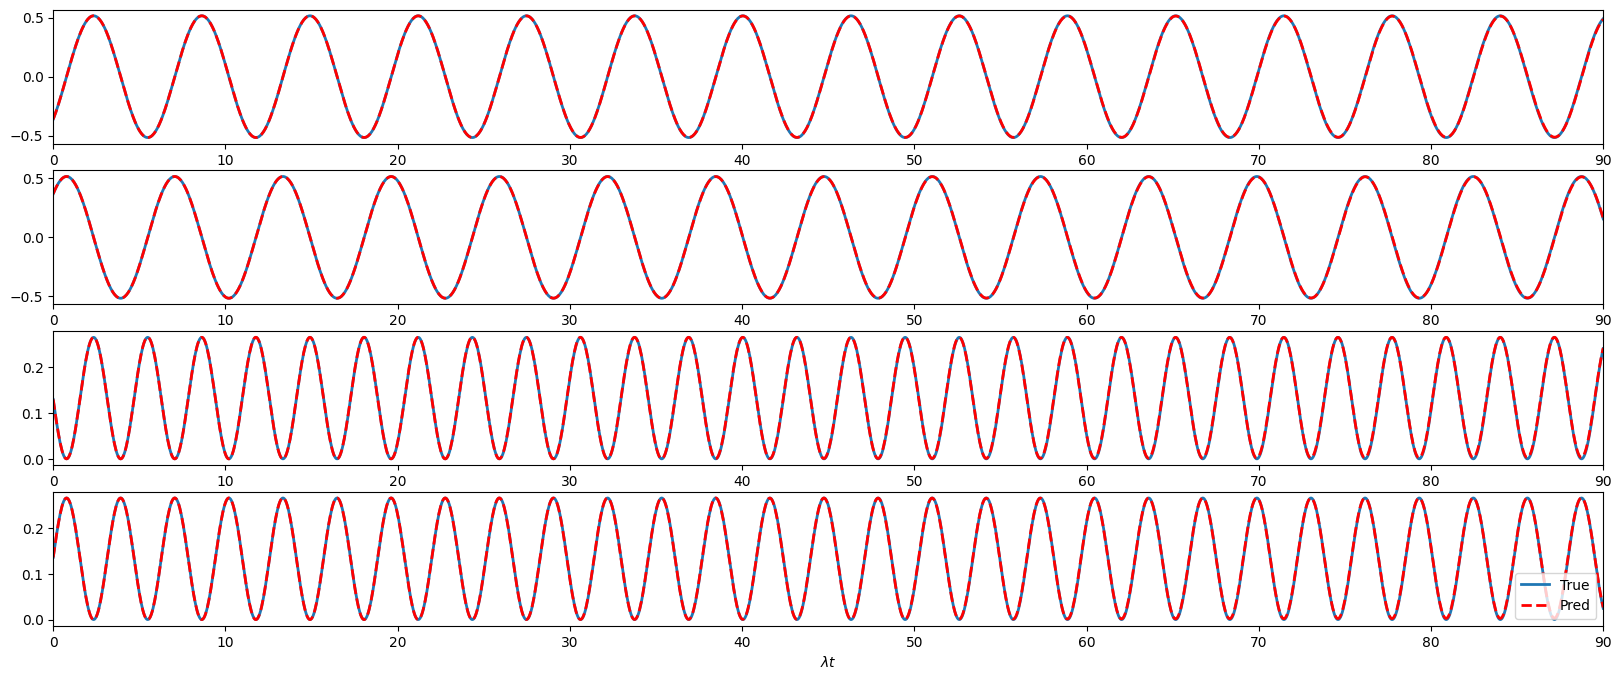

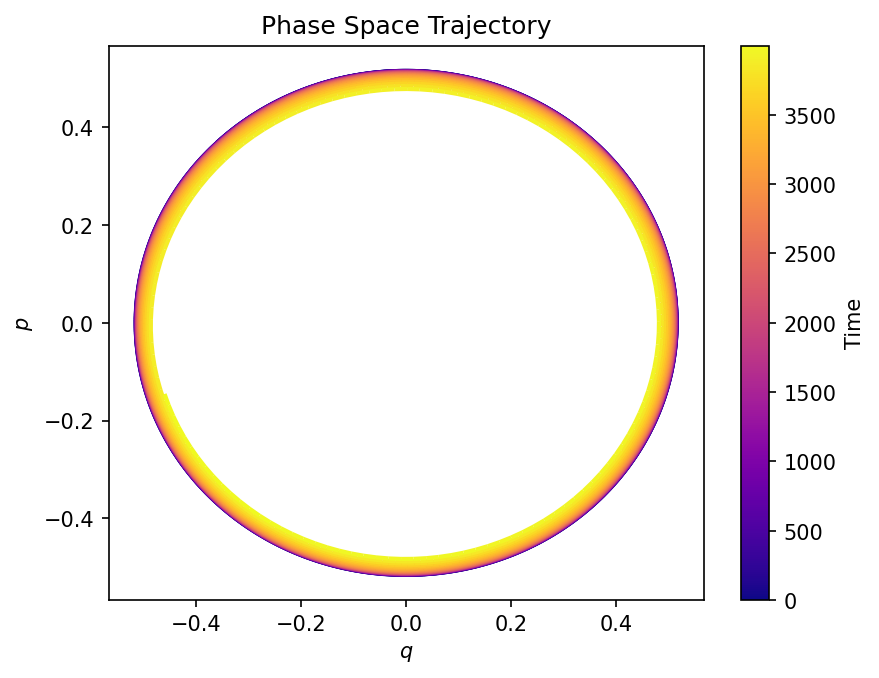

In [4]:
RC = perc.ReservoirComputer(**RC_CONFIG)
_ = RC.train(U_train)
U_pred = RC.forecast(FCAST_LEN)

C_err_uc = (C@U_pred - d).reshape(-1)[:U_test.shape[1]]
E_uc = calc_energy(U_pred[:2,:])#[:U_test.shape[1]]

vis.plot_time_series_pred(
    U_test,
    U_pred[:,:U_test.shape[1]],
    t_test
)

vis.plot_phase_space(U_pred[:2,:])

# Train Constrained RC

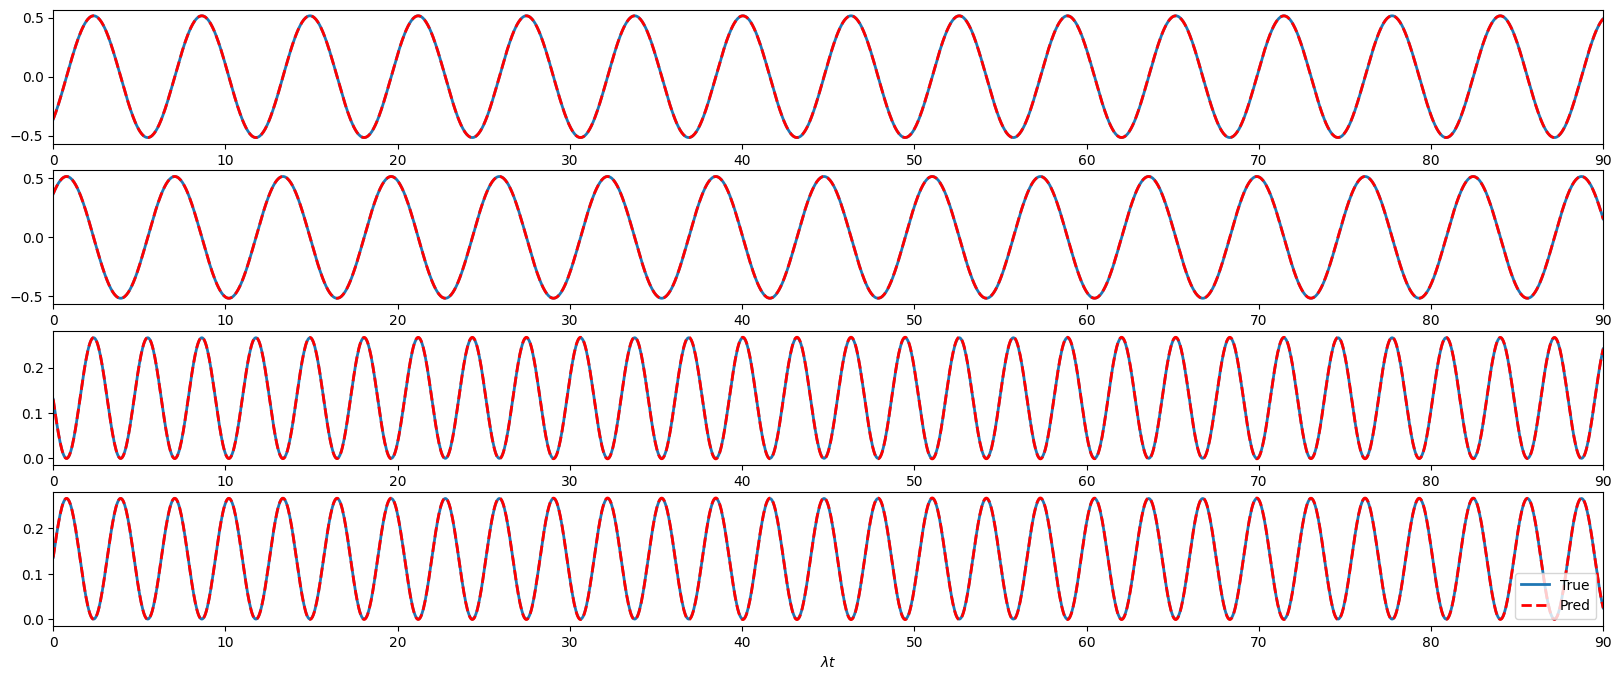

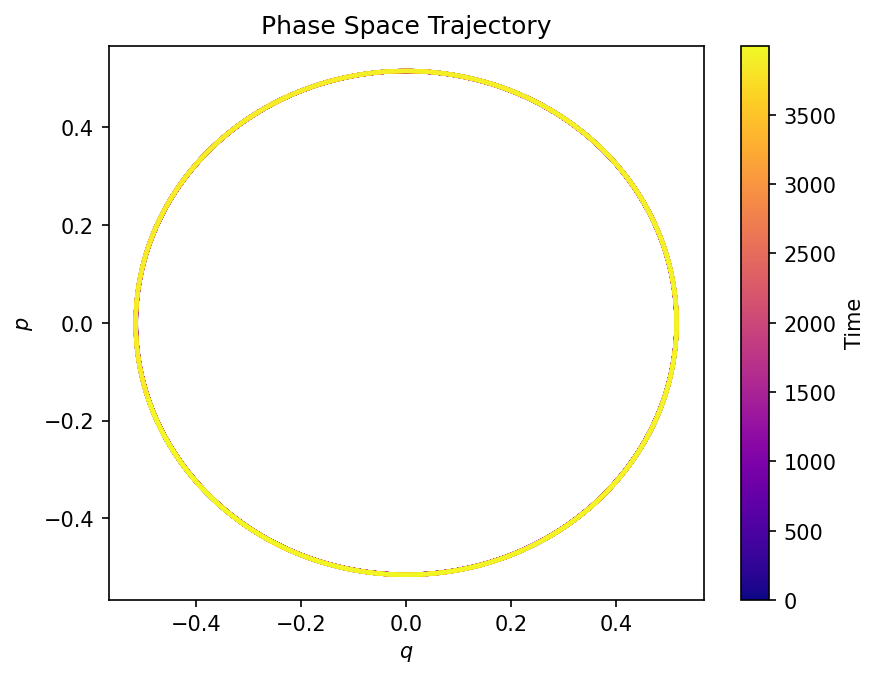

In [5]:
### Train Constrained RC ###
RC = perc.ReservoirComputer(**RC_CONFIG)
_ = RC.train_lih(U_train,C,d,
                     solver = cp.SCS,
                     warm_start = True)
U_pred = RC.forecast_lih(FCAST_LEN)[:-1,:]

C_err_c = (C@U_pred - d).reshape(-1)[:U_test.shape[1]]
E_c = calc_energy(U_pred[:2,:])#[:U_test.shape[1]]

vis.plot_time_series_pred(
    U_test,
    U_pred[:,:U_test.shape[1]],
    t_test
)

vis.plot_phase_space(U_pred[:2,:])

# Compare Errors 

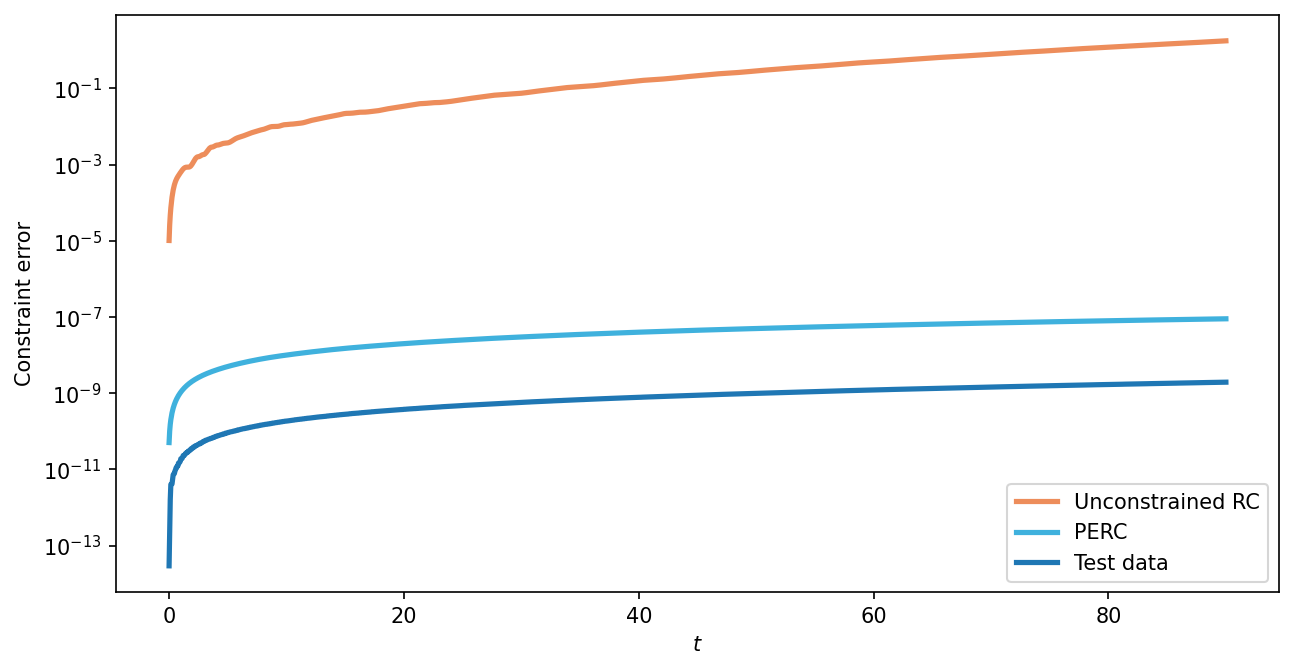

In [6]:
# make err cumulative
C_err_utest = np.cumsum(np.abs(C_err_utest))
C_err_uc = np.cumsum(np.abs(C_err_uc))
C_err_c = np.cumsum(np.abs(C_err_c))

# plot
lw = 2.5
UCRC_color = "#ed8d5b"
PERC_color = "#3fb1dd"
plt.figure(figsize=(10,5), dpi=150)
plt.plot(t_test, C_err_uc, label = 'Unconstrained RC', linewidth=lw, color=UCRC_color)
plt.plot(t_test, C_err_c, label = 'PERC', linewidth=lw, color=PERC_color)
plt.plot(t_test, C_err_utest, label = 'Test data', linewidth=lw)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel('Constraint error')
plt.show()

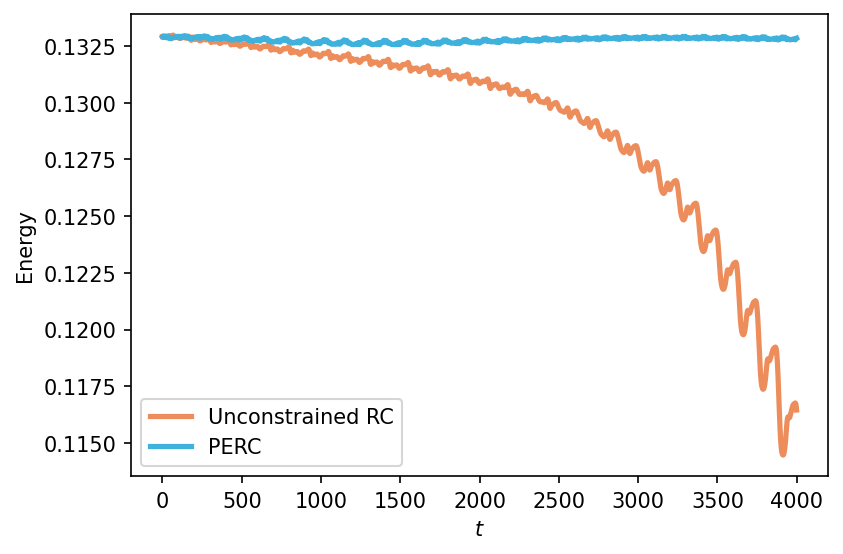

In [7]:
# plot energy 
lw = 2.5
UCRC_color = "#ed8d5b"
PERC_color = "#3fb1dd"
E_utest = calc_energy(U_test[:2,:])
plt.figure(figsize=(6,4), dpi=150)
plt.plot(E_uc, label = "Unconstrained RC", linewidth=lw, color=UCRC_color)
plt.plot(E_c, label = "PERC", linewidth=lw, color=PERC_color)
# plt.plot(t_test, E_utest, label = "Test Data", linewidth=lw)
plt.xlabel(r'$t$')
plt.ylabel("Energy")
plt.legend()
plt.show()